In [1]:
import os
import sys
import numpy as np
import pandas as pd
import csv
import open3d as o3d
from matplotlib import pyplot as plt
import scipy
import scipy.io
import skimage
import ssm_utils
from recons_eval_metric import computeRMSE, computeRMSD, computeASSD, computeHD, computeChamferDistance
import projection_utils as proj
import functools
import ray
import psutil
from projection_utils import PHOTO
from emopt5views_parallel_rotvec_grad import EMOpt5Views

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [136]:
# SSM_DIR = r"./data/cpdAlignedData/eigValVec/" 
# CPD_ALIGNED_DIR = r"./data/cpdAlignedData/" 
# PARAM_DIR = r"./data/params/" 
# SRC_DIR = r"./dataWithPhoto/cpdAlignedData/"
# SRC_PARAM_DIR = r"./dataWithPhoto/params/" 

SSM_DIR = r"./data/cpdGpAlignedData/eigValVec/" 
CPD_ALIGNED_DIR = r"./data/cpdGpAlignedData/" 
PARAM_DIR = r"./data/cpdGpParams/" 
SRC_DIR = r"./dataWithPhoto/cpdGpAlignedData/"
SRC_PARAM_DIR = r"./dataWithPhoto/cpdGpParams/"

NUM_PC = 10 # 3
NUM_POINT = 1500
PG_SHAPE = (NUM_POINT, 3)
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"

PG_NPY = os.path.join(SRC_PARAM_DIR, "Y_pg.npy")
MASK_NPY = os.path.join(SRC_PARAM_DIR, "X_mask.npy")

MATLAB_PATH = r"./matlab_script"

TagID = 47
FOLD_IDX = 5 # change this index each fold
VERSION = "v21" # version of teeth silouette extraction model
EDGE_MASK_PATH = r"./dataWithPhoto/learning/fold{}/test/pred-{}/".format(FOLD_IDX,VERSION)
# EDGE_MASK_PATH = r".\dataWithPhoto\normal_mask_v2"
STAGE0_MAT_DIR = os.path.join(MATLAB_PATH, "stage0-mat")
# DEMO_H5_DIR = r"./dataWithPhoto/demo/"
# DEMO_MESH_DIR = r"./dataWithPhoto/demoMesh/"
NAME_IDX_CSV = pd.read_csv(NAME_IDX_MAP_CSV)

# LOG_DIR = r"./dataWithPhoto/log/"
# print = functools.partial(print, flush=True)

# # Run it only once
# ssm_utils.saveEigValVec(CPD_ALIGNED_DIR, NumPC2Save=100)

# # Run it only once
# src_invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=SRC_PARAM_DIR) # 加载待优化点云配准过程中的参数
# Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
# Y_pg, X_mask, Y_scale, Y_rxyz, Y_txyz, Y_fVec = proj.loadDataSet(src_invRegistrationParamDF, Mu, Sigma, pgShape=PG_SHAPE, srcRootDir=SRC_DIR)
# np.save(PG_NPY, np.array(Y_pg))
# np.save(MASK_NPY, np.array(X_mask))

In [137]:
# phase 0: grid search parallelled by Ray
# phase 1: stage 0,1,2,3 optimization by scipy

print("TagID: ", TagID)

# 顺序相互对应
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]
edgeMasks = proj.getEdgeMask(EDGE_MASK_PATH, NAME_IDX_CSV, TagID, photo_types, resized_width=800, binary=True, activation_thre=0.1)
# proj.visualizeEdgeMasks(edgeMasks, photo_types)

Mu, SqrtEigVals, Sigma = proj.loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
Mu_normals = EMOpt5Views.computePointNormals(Mu)

invRegistrationParamDF = proj.loadInvRegistrationParams(loadDir=PARAM_DIR) # 加载配准过程中的参数
invParamDF = proj.updateAbsTransVecs(invRegistrationParamDF, Mu) # 将牙列scale转化为每颗牙齿的位移，将每颗牙齿的transVecXYZs在局部坐标系下进行表达

invScaleMeans, invScaleVars, invRotVecXYZMeans, invRotVecXYZVars, invTransVecXYZMeans, invTransVecXYZVars = proj.getMeanAndVarianceOfInvRegistrationParams(invParamDF)
scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotVecStds = np.sqrt(invRotVecXYZVars)
print("scaleStd: {:.4f}, transVecStd: {:.4f}, rotVecStd: {:.4f}".format(scaleStds.mean(), transVecStds.mean(), rotVecStds.mean()))

PoseCovMats = proj.GetPoseCovMats(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 每个位置的牙齿的6个变换参数的协方差矩阵,shape=(28,6,6)
ScaleCovMat = proj.GetScaleCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES) # 牙齿scale的协方差矩阵,shape=(28,28)

Mask = proj.GetMaskByTagId(MASK_NPY, TagId=TagID)
# reference pointcloud
PG_Ref = proj.GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref = PG_Ref[Mask]

TagID:  47
['./dataWithPhoto/learning/fold5/test/pred-v21/曾思棋_219446_上牙列.png', './dataWithPhoto/learning/fold5/test/pred-v21/曾思棋_219446_下牙列.png', './dataWithPhoto/learning/fold5/test/pred-v21/曾思棋_219446_左侧咬合.png', './dataWithPhoto/learning/fold5/test/pred-v21/曾思棋_219446_右侧咬合.png', './dataWithPhoto/learning/fold5/test/pred-v21/曾思棋_219446_正位像.png']
scaleStd: 0.0665, transVecStd: 1.1463, rotVecStd: 0.1391


In [138]:
# Optimization

print("-"*100)
print("Start optimization.")
# 初始化
photoTypes = [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
VISIBLE_MASKS = [proj.MASK_UPPER, proj.MASK_LOWER, proj.MASK_LEFT, proj.MASK_RIGHT, proj.MASK_FRONTAL]
emopt = EMOpt5Views(edgeMasks, photoTypes, VISIBLE_MASKS, Mask, Mu, Mu_normals, SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStds.mean(), rotVecStds.mean())

stage0initMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage0-init-{}.mat".format(TagID))
stage0finalMatFile = os.path.join(STAGE0_MAT_DIR, "TEMP-E-step-result-stage0-final.mat")
# stage2initMatFile = os.path.join(STAGE0_MAT_DIR, "E-step-result-stage2-init-{}.mat".format(TagID))


# print("num of observed edge points: ", emopt.M)
# print("ex_rxyz: ", emopt.ex_rxyz)
# print("ex_txyz: ", emopt.ex_txyz)
# print("rela_rxyz: ", emopt.rela_rxyz)
# print("rela_txyz: ", emopt.rela_txyz)
# print("focal length: ", emopt.focLth)
# print("d_pixel: ", emopt.dpix)
# print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
# print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))
# print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(emopt.X_trans, X_Ref)))
# print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(emopt.X_trans, X_Ref)))

----------------------------------------------------------------------------------------------------
Start optimization.


In [9]:
# phase 0: grid search parallelled by Ray


print("-"*100)
print("Start Grid Search.")

# parallel function supported by Ray
emopt.searchDefaultRelativePoseParams()
emopt.gridSearchExtrinsicParams()
emopt.gridSearchRelativePoseParams()

print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
emopt.expectation_step_5Views(-1, verbose=True)

# emopt.save_expectation_step_result_with_XRef(stage0initMatFile, X_Ref)

In [139]:
# phase 1: stage 0 & 1 optimization by Matlab


maxiter = 20
stageIter = [10,5,10]

print("-"*100)
print("Start Stage 0.")
# Continue from checkpoint "E-step-result-stage0-init-{}.mat"
stage = 0
emopt.load_expectation_step_result(stage0initMatFile, stage)
emopt.expectation_step_5Views(stage, verbose=True)
print("Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))        

----------------------------------------------------------------------------------------------------
Start Stage 0.
PHOTO.UPPER - unique pred points: 1083 - E-step loss: 42.88
PHOTO.LOWER - unique pred points: 956 - E-step loss: 33.09
PHOTO.LEFT - unique pred points: 818 - E-step loss: 48.09
PHOTO.RIGHT - unique pred points: 865 - E-step loss: 45.73
PHOTO.FRONTAL - unique pred points: 1144 - E-step loss: 46.07
Root Mean Squared Surface Distance(mm): 1.5960


In [ ]:
E_loss = []
for it in range(stageIter[0]):
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)

    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        E_loss.append(e_loss)
        break
    else:
        E_loss.append(e_loss)
        
# emopt.save_expectation_step_result_with_XRef(stage0finalMatFile, X_Ref)

In [ ]:
skipStage1Flag = False
print("-"*100)
print("Start Stage 1.")

stage = 1
for it in range(stageIter[1]): 
    emopt.maximization_step_5Views(stage, step=-1, maxiter=maxiter, verbose=False)

    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if e_loss >= E_loss[-1]: # len(E_loss)>=2 and e_loss>=np.mean(E_loss[-2:]):
        # 判断条件1：是否跳过stage1
        if it == 0:
            skipStage1Flag = True # first optimization with rowScaleXZ gets worse result compared with optimziaiton without rowScaleXZ
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))

In [ ]:
# 判断是否跳过stage1
if skipStage1Flag == True:
    print("Skip Stage 1; Reverse to Stage 0 final result.")
    emopt.rowScaleXZ = np.ones((2,))
    emopt.load_expectation_step_result(stage0finalMatFile, stage=2)
    emopt.expectation_step_5Views(stage, verbose=True)
else:
    print("Accept Stage 1.")
    emopt.anistropicRowScale2ScalesAndTransVecs()      
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

# 保存用于phase2的初始变量
# emopt.save_expectation_step_result_with_XRef(stage2initMatFile, X_Ref)

In [ ]:
# Stage = 2
print("-"*100)
print("Start Stage 2.")
stage = 2

# # load previous data
# emopt.load_expectation_step_result(stage2initMatFile, stage)
emopt.expectation_step_5Views(stage, verbose=True)


E_loss = []
for it in range(stageIter[2]):
    # emopt.maximization_step_5Views(stage=2, step=4, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=2, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=3, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage=3, step=-1, maxiter=maxiter, verbose=False)
    emopt.maximization_step_5Views(stage, step=1, maxiter=maxiter, verbose=False)
    print("M-step loss: {:.4f}".format(emopt.loss_maximization_step))
    emopt.expectation_step_5Views(stage=3, verbose=True)
    e_loss = np.sum(emopt.weightViews * emopt.loss_expectation_step)
    print("Sum of expectation step loss: {:.4f}".format(e_loss))
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
    if len(E_loss)>=2 and (e_loss>=np.mean(E_loss[-2:])):
        print("Early stop with last 3 e-step loss {:.4f}, {:.4f}, {:.4f}".format(E_loss[-2],E_loss[-1],e_loss))
        break
    else:
        E_loss.append(e_loss)


print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(X_Ref, emopt.X_trans)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(X_Ref, emopt.X_trans)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(X_Ref, emopt.X_trans)))

In [ ]:
print("-"*100)
print("Evaluation.")

invRotVecXYZVars = invRotVecXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[Mask]))
print("standard rotVecXYZs:")
print((emopt.rotVecXYZs - emopt.meanRotVecXYZs) / np.sqrt(invRotVecXYZVars[Mask]))
print("scales:")
print(emopt.scales)
print("feature vectors:")
print(emopt.featureVec)

# 不考虑第二磨牙
withoutSecondMolarMask = np.tile(np.array([1,1,1,1,1,1,0],dtype=np.bool_),(4,))
print("Without Second Molar, Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans[withoutSecondMolarMask[Mask]], X_Ref[withoutSecondMolarMask[Mask]])))

# # Save Demo Result

# demoH5File = os.path.join(DEMO_H5_DIR, "demo_TagID={}.h5".format(TagID))
# emopt.saveDemo2H5(demoH5File, TagID, X_Ref)

In [153]:
def showEdgeMaskPredictionWithGroundTruth(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
    canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

def showEdgePrediction(emopt, photoType, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    # canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(3)) # dilation edge prediction for visualization
    canvas[:,:,0] = edgePred

    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

def showPointCorrespondence(emopt, photoType, canvasShape=None, dilate=True, filtering=True):
    # red: prediction, white: ground truth
    ph = photoType.value
    if not bool(canvasShape):
        canvasShape = emopt.edgeMask[ph].shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float64)
    h, w = emopt.edgeMask[ph].shape
    canvas[:h,:w,:] = emopt.edgeMask[ph][:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float64)
    pix_pred = emopt.P_pred[ph].astype(np.int32)
    edgePred[pix_pred[:,1], pix_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
        
    line_img = np.zeros(canvasShape, dtype=np.float64)
    pred_ids = emopt.corre_pred_idx[ph]
    p_true = emopt.P_true_99_percentile[ph]
    if not filtering:
        p_true = emopt.P_true[ph]
    for i in range(p_true.shape[0]):
        j = pred_ids[i]
        if i % 2 == 0:
            rr, cc = skimage.draw.line(pix_pred[j,1],pix_pred[j,0],p_true[i,1],p_true[i,0])
            line_img[rr,cc] = 1.
        
    canvas[:,:,0] = np.maximum(edgePred,canvas[:,:,0])
    canvas[:,:,1] = np.maximum(line_img, canvas[:,:,1])
    
    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(canvas)
    return canvas

def EMOPT_expectation_step_5Views(emopt, stage, use_percentile=False, verbose=True):
    # 根据新的edgePredcition计算对应点对关系,对5张图同时进行
    tIdx = [i for i in range(emopt.numTooth)]
    emopt.updateAlignedPointCloudInWorldCoord(stage, tIdx)
    for photoType in emopt.photoTypes:
        emopt.updateEdgePrediction(photoType)
        emopt.expectation(photoType, verbose, use_percentile=False)

In [ ]:
emopt.expectation_step_5Views(stage=2, verbose=True)
for ptype in emopt.photoTypes:
    _ = showPointCorrespondence(emopt, ptype, canvasShape=None, dilate=True)

In [ ]:
EMOPT_expectation_step_5Views(emopt, stage=2, use_percentile=False, verbose=True)
for ptype in emopt.photoTypes:
    _ = showPointCorrespondence(emopt, ptype, canvasShape=None, dilate=True, filtering=False)

In [ ]:
for ptype in emopt.photoTypes:
    _ = showEdgeMaskPredictionWithGroundTruth(emopt, ptype, canvasShape=None, dilate=True)

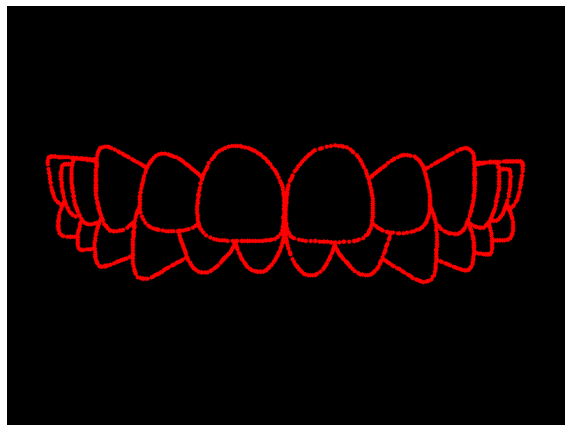

In [14]:
_ = showEdgePrediction(emopt, PHOTO.FRONTAL, canvasShape=None, dilate=True)